pinecone

In [1]:
from dotenv import load_dotenv
import os
# .env 파일에서 환경 변수를 로드합니다.
load_dotenv()

# 환경 변수에서 PINECONE_API_KEY를 가져옵니다.
PINECONE_API_KEY = os.environ['PINECONE_API_KEY']

# index 생성

In [2]:
from pinecone import Pinecone

# 클라이언트 생성
pinecone_client = Pinecone(api_key=PINECONE_API_KEY)

In [3]:
pinecone_client

## 클라이언트.create_index

In [ ]:
from pinecone import ServerlessSpec
pinecone_client.create_index(
    name='embedding-3d',
    dimension=3,
    metric='cosine',
    spec=ServerlessSpec(
        cloud='aws',
        region='us-east-1'
    )
)

In [ ]:
index = pinecone_client.Index('embedding-3d')
index

In [ ]:
index.describe_index_stats() # 'total_vector_count': 0

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

In [ ]:
for ids in index.list(namespace='embedding-3d-ns1'):
    print(ids) # 없어서 안나옴

# pinecone data 형식 [{'id', 'value', 'metadata'}]
      
[{ 'id' : 'vec1' , 'values' : [1.0, 1.5, 2.0] , 'metadata' : {'genre':'drama'}},      
{ 'id' : 'vec2' , 'values' : [2.0, 0.5, 0.5] , 'metadata' : {'genre':'action'}},       
{ 'id' : 'vec3' , 'values' : [0.1, 0.3, 0.5] , 'metadata' : {'genre':'drama'}},     
{ 'id' : 'vec4' , 'values' : [1.0, 2.5, 3.5] , 'metadata' : {'genre':'action'}},     
{ 'id' : 'vec5' , 'values' : [3.0, 1.2, 1.3] , 'metadata' : {'genre':'action'}},    
{ 'id' : 'vec6' , 'values' : [0.3, 1.1, 2.5] , 'metadata' : {'genre':'drama'}},     
]    

In [ ]:
index.upsert( # update + insert
[
    { 'id' : 'vec1' , 'values' : [1.0, 1.5, 2.0] , 'metadata' : {'genre':'drama'}},
    { 'id' : 'vec2' , 'values' : [2.0, 0.5, 0.5] , 'metadata' : {'genre':'action'}},
    { 'id' : 'vec3' , 'values' : [0.1, 0.3, 0.5] , 'metadata' : {'genre':'drama'}},
    { 'id' : 'vec4' , 'values' : [1.0, 2.5, 3.5] , 'metadata' : {'genre':'action'}},
    { 'id' : 'vec5' , 'values' : [3.0, 1.2, 1.3] , 'metadata' : {'genre':'action'}},
    { 'id' : 'vec6' , 'values' : [0.3, 1.1, 2.5] , 'metadata' : {'genre':'drama'}},
], namespace='embedding-3d-ns1'
)

In [ ]:
index.describe_index_stats() # 'total_vector_count': 6

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

In [ ]:
for ids in index.list(namespace='embedding-3d-ns1'):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


# query

In [ ]:
response = index.query(
    namespace='embedding-3d-ns1',
    vector=[0.1, 0.4, 0.7], # 이거랑 비슷한 애 나오는데
    top_k=3,
    include_values=True,
    include_metadata=True,
    filter={'genre': {'$eq':'drama'}}  # 필터까지 하면 $eq  = drama 인 것 나옴
)

response

{'matches': [{'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 1.00008953,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.99550879,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.961182,
              'values': [1.0, 1.5, 2.0]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 1}}

In [ ]:
response = index.query(
    namespace='embedding-3d-ns1',
    vector=[0.1, 0.4, 0.7], # 이거랑 비슷한 애 나오는데
    top_k=3,
    include_values=True,
    include_metadata=True,
    filter={'genre': {'$eq':'drama'}}  # 필터까지 하면 $eq drama 인 것 나옴
)

response

{'matches': [{'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 1.00008953,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.99550879,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.961182,
              'values': [1.0, 1.5, 2.0]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 1}}

In [ ]:
ns = 'embedding-3d-ns1'
for ids in index.list(namespace=ns):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


# fatch

In [ ]:
from itertools import chain

all_ids = list(chain.from_iterable(index.list(namespace=ns)))
resp = index.fetch(ids=all_ids, namespace=ns)
resp

FetchResponse(namespace='embedding-3d-ns1', vectors={'vec6': Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None), 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None), 'vec5': Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None), 'vec2': Vector(id='vec2', values=[2.0, 0.5, 0.5], metadata={'genre': 'action'}, sparse_values=None), 'vec4': Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None), 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None)}, usage={'read_units': 1})

In [ ]:
resp.vectors

{'vec6': Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec5': Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None),
 'vec2': Vector(id='vec2', values=[2.0, 0.5, 0.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec4': Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None)}

In [ ]:
for vid, v in resp.vectors.items():
    vid,v.values

# page - 1개씩 벡터 꺼내기

In [ ]:
for id_page in index.list(namespace=ns):
    resp = index.fetch(ids=id_page, namespace=ns)
    for vid,v in resp.vectors.items():
        print(vid, v.values)

vec1 [1.0, 1.5, 2.0]
vec3 [0.1, 0.3, 0.5]
vec2 [2.0, 0.5, 0.5]
vec4 [1.0, 2.5, 3.5]
vec5 [3.0, 1.2, 1.3]
vec6 [0.3, 1.1, 2.5]


In [ ]:
ids = list(resp.vectors.keys())
ids

['vec1', 'vec3', 'vec2', 'vec4', 'vec5', 'vec6']

In [ ]:
values = [vec.values for vec in resp.vectors.values()]

In [ ]:
ids.append('qv')
values.append([0.1,0.3,0.7]) # dimesion 일치

# 시각화

In [ ]:
# pip install matplotlib

  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------------------------------- - 7.9/8.1 MB 40.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 38.7 MB/s  0:00:00
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 42.4 MB/s  0:00:00
Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]

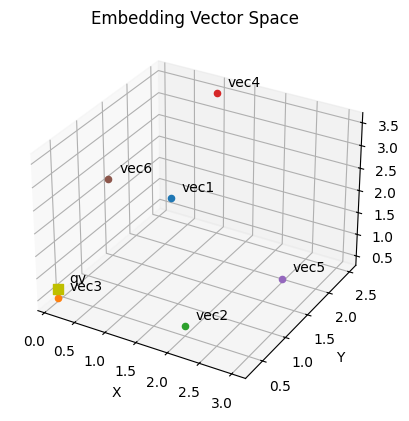

In [ ]:
import matplotlib.pyplot as plt

# 3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()

# 실습

"quickstart" 서버리스 인덱스 생성
dim : 1024, 

임베딩 모델   
multilingual-e5-large   

upsert()   
    
describe_index_stats()   
    
query_vector : "애플이라는 기술 회사에 대해 알려주세요."

index.query()


In [ ]:
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

In [ ]:
# quickstart 인덱스 생성
from pinecone import ServerlessSpec
pinecone_client.create_index(
    name='quickstart',
    dimension=1024,
    metric='cosine',
    spec=ServerlessSpec(
        cloud='aws',
        region='us-east-1'
    )
)

{
    "name": "quickstart",
    "metric": "cosine",
    "host": "quickstart-1az4ojo.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1024,
    "deletion_protection": "disabled",
    "tags": null
}

In [ ]:
index = pinecone_client.Index('quickstart')
index

NameError: name 'pinecone_client' is not defined

In [ ]:
index.describe_index_stats() # 'total_vector_count': 0

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

In [ ]:
# pip install pinecone-client sentence-transformers torch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# pip install sentence-transformers pinecone-client

In [ ]:
from pinecone import Pinecone
from sentence_transformers import SentenceTransformer

# 1. 사용자 데이터
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

# 2. 임베딩 모델 로드 (클라이언트 측에서 직접 임베딩)
model = SentenceTransformer('intfloat/multilingual-e5-large')

# 3. Pinecone 클라이언트 및 인덱스 연결
# 실제 API 키와 인덱스 이름으로 변경하세요.
index = pinecone_client.Index("quickstart")

# 4. 데이터를 Pinecone 'upsert' 형식에 맞게 변환
vectors_to_upsert = []
for item in data:
    # 텍스트를 벡터로 변환
    embedding = model.encode(item["text"]).tolist()
    
    # 'values' 필드에 벡터를, 'metadata'에 원본 텍스트를 저장
    vector_data = {
        "id": item["id"],
        "values": embedding,
        "metadata": {"text": item["text"]}
    }
    vectors_to_upsert.append(vector_data)

# 5. 'upsert()' 함수를 사용하여 데이터 업로드
# ✅ index.upsert_records() 대신 index.upsert()를 사용합니다.
index.upsert(
    vectors=vectors_to_upsert,
    namespace="quickstart"  # namespace는 동일하게 사용 가능
)

# 6. 결과 확인
print(index.describe_index_stats())

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'quickstart': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}


In [ ]:
index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'quickstart': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

In [ ]:
from itertools import chain

all_ids = list(chain.from_iterable(index.list(namespace='quickstart')))
resp = index.fetch(ids=all_ids, namespace='quickstart')

resp.vectors

{'vec3': Vector(id='vec3', values=[0.0289529469, 0.00682831835, -0.0128225107, -0.0194114223, 0.0238625873, -0.0326877609, 0.000174178393, 0.0472014695, 0.0466628149, -0.0205455367, 0.0448068306, 0.0030337458, -0.0475233, -0.0250152983, -0.0440067686, -0.0348797776, -0.0302503668, 0.0207060091, 0.00664330041, 0.0116812186, 0.025489226, -0.00813879538, -0.0445756093, -0.0104217995, -0.0298061259, -0.0118054198, -0.00959262624, -0.025599204, -0.0293261446, -0.0579843894, -0.0145371994, 0.00608792296, -0.0482655, -0.0448376238, 0.00532114226, 0.0399969295, 0.0429276861, 0.0161576662, -0.0149982525, 0.0131611079, -0.011959631, 0.0528362, -0.0104736974, -0.0224371869, -0.0230666548, 0.0193939917, 0.0192722958, 0.025185097, -0.0162240956, 0.0241044108, 0.0326035284, 0.0127099743, -0.00139521621, -0.0373684913, -0.032343138, 0.0235456508, -0.0218733866, 0.0102228066, -0.0444237962, 0.0264054, -0.0158349443, -0.0094103, 0.0311031155, -0.0309386607, -0.0367207, 0.032432992, 0.0662860498, 0.0008

In [ ]:
qs = 'quickstart'

In [ ]:
response = index.query(
    namespace=qs,
    vector=[0.1, 0.4, 0.7], # 이거랑 비슷한 애 나오는데
    top_k=3,
    include_values=True,
    include_metadata=True,
    filter={'genre': {'$eq':'drama'}}  # 필터까지 하면 $eq  = drama 인 것 나옴
)

response

In [ ]:
# 벡터값 확인
for id_page in index.list(namespace=qs):
    resp = index.fetch(ids=id_page, namespace=qs)
    for vid,v in resp.vectors.items():
        print(vid, v.values)

vec3 [0.0289529469, 0.00682831835, -0.0128225107, -0.0194114223, 0.0238625873, -0.0326877609, 0.000174178393, 0.0472014695, 0.0466628149, -0.0205455367, 0.0448068306, 0.0030337458, -0.0475233, -0.0250152983, -0.0440067686, -0.0348797776, -0.0302503668, 0.0207060091, 0.00664330041, 0.0116812186, 0.025489226, -0.00813879538, -0.0445756093, -0.0104217995, -0.0298061259, -0.0118054198, -0.00959262624, -0.025599204, -0.0293261446, -0.0579843894, -0.0145371994, 0.00608792296, -0.0482655, -0.0448376238, 0.00532114226, 0.0399969295, 0.0429276861, 0.0161576662, -0.0149982525, 0.0131611079, -0.011959631, 0.0528362, -0.0104736974, -0.0224371869, -0.0230666548, 0.0193939917, 0.0192722958, 0.025185097, -0.0162240956, 0.0241044108, 0.0326035284, 0.0127099743, -0.00139521621, -0.0373684913, -0.032343138, 0.0235456508, -0.0218733866, 0.0102228066, -0.0444237962, 0.0264054, -0.0158349443, -0.0094103, 0.0311031155, -0.0309386607, -0.0367207, 0.032432992, 0.0662860498, 0.000861115113, -0.0538132042, 0.01

### query_vector : "애플이라는 기술 회사에 대해 알려주세요." 확인

In [ ]:
# 임베딩 모델 로드
# 데이터를 인덱싱할 때 사용했던 것과 "반드시 동일한 모델"을 사용
model = SentenceTransformer('intfloat/multilingual-e5-large')

# 검색 쿼리
query_text = "애플이라는 기술 회사에 대해 알려주세요."

# 쿼리 문장 임베딩
query_vector = model.encode(query_text).tolist()

# Pinecone 인덱스에 쿼리 실행
# index.query() 함수를 사용하여 유사도 검색
query_results = index.query(
    namespace="quickstart",
    vector=query_vector,
    top_k=3,  # 가장 유사한 결과 3개
    include_metadata=True  # 'metadata'에 저장된 원본 텍스트를 함께 반환
)

# 결과 출력
print(f'쿼리: "{query_text}"')
print("-" * 50)
print("검색 결과:")

for result in query_results['matches']:
    print(f"  - ID: {result['id']}")
    print(f"    유사도 점수: {result['score']:.4f}")
    print(f"    원본 텍스트: {result['metadata']['text']}")
    # metadata에 저장된 원본 텍스트를 출력합니다.
    if 'original_text' in result['metadata']:
        print(f"    원본 텍스트: {result['metadata']['text']}")
    print()

쿼리: "애플이라는 기술 회사에 대해 알려주세요."
--------------------------------------------------
검색 결과:
  - ID: vec2
    유사도 점수: 0.9059
    원본 텍스트: 애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.

  - ID: vec4
    유사도 점수: 0.8865
    원본 텍스트: 애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다.

  - ID: vec6
    유사도 점수: 0.8537
    원본 텍스트: 애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다.



### 쿼리 작성 미션

In [ ]:
quick_index = pinecone_client.Index('quickstart')

In [ ]:
# 쿼리 텍스트를 정의합니다.
query = "애플이라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pinecone_client.inference.embed(
    model="multilingual-e5-large",
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embedding[0])

{'vector_type': dense, 'values': [0.0113525390625, -0.0175933837890625, ..., -0.02020263671875, -0.00698089599609375]}


In [ ]:
results = quick_index.query(
    namespace="quickstart_ns1",
    vector=embedding[0].values,
    top_k=3,
    include_values=False,
    include_metadata=True
)

# 검색 결과를 출력합니다.
print(results)

{'matches': [], 'namespace': 'quickstart_ns1', 'usage': {'read_units': 1}}
